# Food Image Classification for the course _Foundations of Deep Learning_.

Professors:
Paolo Napoletano
Marco Buzzelli

Tutor:
Mirko Agarla

[TODO]
- Introduce the problem you are trying to solve
- Show an analysis of the available data (EDA for images)
- Describe your solution
- Comment positive and negative results of your solution
(rely on quantitative and qualitative observations)
- Describe alternative (possibly failed) experiments

Dataset: \\
_Example Food Images_
- https://de.mathworks.com/help/deeplearning/ug/data-sets-for-deep-learning.html

The Example Food Images data set contains 978 photographs of food in nine classes (caesar_salad, caprese_salad, french_fries, greek_salad, hamburger, hot_dog, pizza, sashimi, and sushi).

References:
- https://github.com/TetsumichiUmada/food_app
  - https://github.com/TetsumichiUmada/food_app/blob/master/1_food_app.ipynb
  - https://github.com/Pyligent/food101-image-classification/blob/master/food-101_EDA_Model_RestNet_final.ipynb
  - https://github.com/TetsumichiUmada/food_app/blob/master/0_dataset.ipynb

- https://github.com/AhmedMaghawry/Food-Image-Recognition/blob/master/Food_Detection.ipynb
- FoodApp: http://blog.stratospark.com/creating-a-deep-learning-ios-app-with-keras-and-tensorflow.html
- https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8
- http://blog.stratospark.com/creating-a-deep-learning-ios-app-with-keras-and-tensorflow.html
- Rejection class: 
  - https://hal.archives-ouvertes.fr/hal-02963115/document
  - https://ai.stackexchange.com/questions/24914/image-classification-need-method-to-classify-unknown-objects-as-trash-3d

- CNN:
  - https://medium.com/free-code-camp/everything-you-need-to-know-to-master-convolutional-neural-networks-ef98ca3c7655

-None of the above class approach:
  - https://arxiv.org/pdf/1511.03719.pdf

- Cat/Dog dataset:
  - https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip
  - https://data-flair.training/blogs/cats-dogs-classification-deep-learning-project-beginners/

- Data augmentation:
  - https://medium.com/mlearning-ai/albumentations-a-python-library-for-advanced-image-augmentation-strategies-752bff3a3da0



Check the following notebook done during class:
- _FDL_E04.ipynb_

# 1.Data Set
In thi section we will describe the data at hand.



> ## Data management



In [1]:
!pip install split-folders # install the package to split the images in TRAIN and TEST folders
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# IMPORT TENSORFLOW/KERAS/SCIKIT-LEARN
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers import Dropout
from keras.layers import Input

# SCIKIT-LEARN/SCIKERAS
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# IMPORT OTHER MODULES
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import fnmatch # to count number of image per folder easily
from shutil import copyfile # to import "copyfile"
import splitfolders # needed to split the images in TRAIN and TEST folders
import random # to select random images from a folder

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# DATA AUGMENTATION FUNCTIONS

# HORIZONTAL FLIP
def horizontal_flip(img, flag):
    if flag:
      return cv2.flip(img, 1)
    else:
      return img

# VERTICAL FLIP
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

# BRIGHTNESS
def brightness(img, low, high):
  # A RANDOM VALUE HAS BEEN CHOOSE BETWEEN THE LOW AND HIGH VALUES
  value = random.uniform(low, high)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  hsv = np.array(hsv, dtype = np.float64)
  hsv[:,:,1] = hsv[:,:,1]*value
  hsv[:,:,1][hsv[:,:,1]>255]  = 255
  hsv[:,:,2] = hsv[:,:,2]*value 
  hsv[:,:,2][hsv[:,:,2]>255]  = 255
  hsv = np.array(hsv, dtype = np.uint8)
  img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return img

def hue_image(image,saturation):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  v = image[:, :, 2]
  v = np.where(v <= 255 + saturation, v - saturation, 255)
  image[:, :, 2] = v

  image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
  return image

In [4]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# # TRANSFER THE DATA FROM THE GOOGLE DRIVE FOLDER TO THE VIRTUAL MACHINE

# # The first path is the "data" folder on my Google Drive, and the second one is the destination in my current runtime
# # https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session
# !cp -r /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/Foundation_of_Deep_Learning/Project_Example_Food/ExampleFoodImageDataset /content/ExampleFoodImageDataset

In [5]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 9 # number of output classes

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test' # path contenente i sottoinsiemi di train, test

In [ ]:
# # REMOVE ANY FOLDER NOT EMPTY IN GOOGLE DRIVE THAT YOU DO NOT NEED
# import shutil

# shutil.rmtree('/content/test')

# 2.Data Exploration
In this section the dataset will be explored.



> ## Exploratory Data Analysis (EDA)



In [6]:
# HOW MANY FOLDERS (CLASSES) DO WE HAVE? WHICH CLASSES DO WE HAVE?
lst = os.listdir(ORIGINAL_DATA) # your directory path
file_names = lst
number_files = len(file_names[1:])
print("Class names:", file_names[1:])
print("Number of classes: ", number_files)

Class names: ['french_fries', 'caprese_salad', 'pizza', 'greek_salad', 'sashimi', 'hot_dog', 'caesar_salad', 'hamburger', 'sushi']
Number of classes:  9


In [7]:
# COUNT THE NUMBER OF ELEMENTS IN EACH CLASS FOLDERS

# FOLDER PATH
count = 0
hist_dict = {}

# ITERATE DIRECTORY
for path in os.listdir(ORIGINAL_DATA):
    # CHECK IF CURRENT PATH IS A FILE
    if os.path.isfile(os.path.join(ORIGINAL_DATA, path)):
      count += 0
    else:
      # IF IS NOT A FILE, IS A DIRECTORY. GET THE FOLDER NAME
      number_of_elements_per_folder = len([entry for entry in os.listdir(ORIGINAL_DATA + "/" + path)])
      print(f"The folder called {path} has a number of element(s) equal to:", number_of_elements_per_folder)
      count += 1
      hist_dict[path] = number_of_elements_per_folder

print()
print('Number of folders:', count, "different classes of food.")

The folder called french_fries has a number of element(s) equal to: 181
The folder called caprese_salad has a number of element(s) equal to: 15
The folder called pizza has a number of element(s) equal to: 299
The folder called greek_salad has a number of element(s) equal to: 24
The folder called sashimi has a number of element(s) equal to: 40
The folder called hot_dog has a number of element(s) equal to: 31
The folder called caesar_salad has a number of element(s) equal to: 27
The folder called hamburger has a number of element(s) equal to: 238
The folder called sushi has a number of element(s) equal to: 124

Number of folders: 9 different classes of food.


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

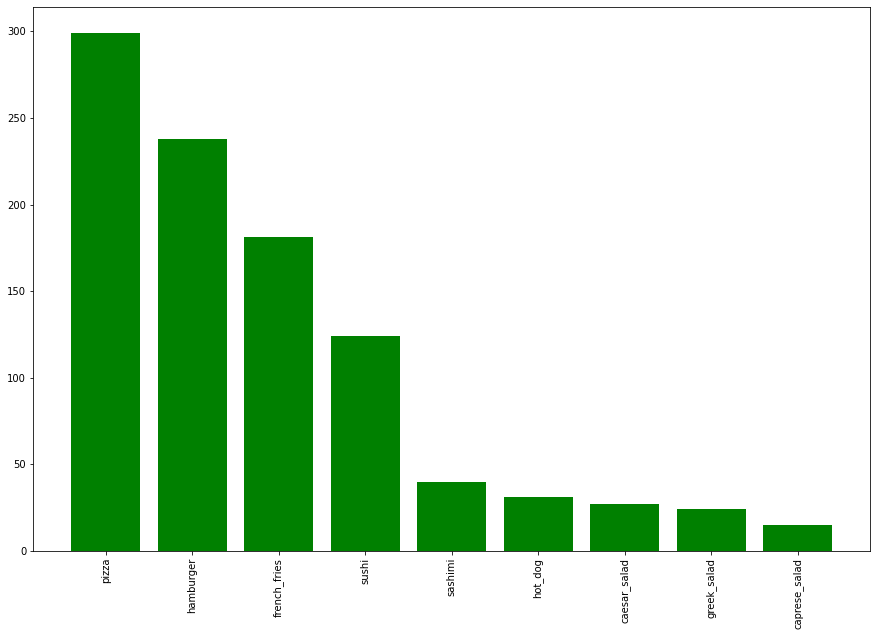

In [8]:
# SHOW THE DATASET DISTRIBUTION WITH A HISTOGRAM PLOT
plt.figure(figsize=(15, 10))
# CONVERT THE DICT TO DATAFRAME
new = pd.DataFrame([hist_dict]).transpose().reset_index()
new = new.rename(columns={"index": "food_name", 0: "value_count"})
# SORT THE DATAFRAME BASED ON VALUE_COUNT
new = new.sort_values("value_count", ascending=False)
new

plt.bar(new['food_name'], new['value_count'], color='g')
plt.xticks(rotation=90)

It is clear that this dataset shows an _unbalanced class problem_ that needs to be addressed through _data augmentation_.

## Show some images as example, their original sizes and the format

As it is visible from the image shape, they are of different sizes but all of them contain the full RGB color spectrum. In order to correctly treat them and feed them inside the CNN it is important that a preprocessing step of resizing them will be applied.



> ### DISPLAY SEVERAL IMAGES AT ONCE
Pick some of the images randomly from the dataset, and show them.


The image corresponding to french_fries has the shape of: (756, 1008, 3)
The image corresponding to caprese_salad has the shape of: (1078, 808, 3)
The image corresponding to pizza has the shape of: (808, 1078, 3)
The image corresponding to greek_salad has the shape of: (159, 212, 3)
The image corresponding to sashimi has the shape of: (381, 557, 3)
The image corresponding to hot_dog has the shape of: (1660, 656, 3)
The image corresponding to caesar_salad has the shape of: (712, 1072, 3)
The image corresponding to hamburger has the shape of: (712, 1072, 3)
The image corresponding to sushi has the shape of: (247, 315, 3)


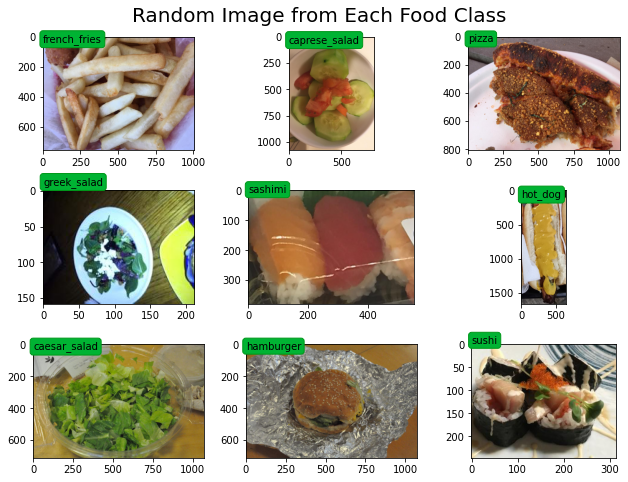

In [9]:
# DECIDE THE NUMBER OF IMAGES PER ROW AND COLUMN TO SHOW
rows = 3
cols = 3

# DEFINE SUBPLOTS BASED ON ROWS AND COLUMNS AND FIGSIZE
fig, ax = plt.subplots(rows, cols, figsize=(9, 7)) # fig = relative to the figure; ax = relative to the axes.
fig.suptitle('Random Image from Each Food Class', fontsize=20) # ADD A TITLE

# CREATE AN EMPTY LIST IN ORDER TO ADD ONLY THE DIRECTORY AND NOT THE FILES
food_dirs = []

# FOR EACH FILE IN ORIGINAL_DATA, CHECK IF IT IS A DIRECTORY AND, IF YES, ADD IT TO THE FOOD_DIRS FOLDER
for filename in os.listdir(ORIGINAL_DATA):
    if os.path.isdir(os.path.join(ORIGINAL_DATA,filename)):
        food_dirs.append(filename)

# PRINT THE FINAL LIST
# print(food_dirs)

# SHOW SOME RANDOM IMAGES FROM THE FOLDERS
for i in range(rows):
    for j in range(cols):
      food_dir = food_dirs[i*cols + j]
      all_files = os.listdir(os.path.join(ORIGINAL_DATA, food_dir))
      rand_img = np.random.choice(all_files)
      img = plt.imread(os.path.join(ORIGINAL_DATA, food_dir, rand_img))
      ax[i][j].imshow(img)
      
      # CREATE COLORS FOR THE BOX AROUND THE TEXT
      ec = (0, .6, .1)
      fc = (0, .7, .2)
      # CREATE THE TEXT ON TOP OF THE IMAGE
      ax[i][j].text(0, -20, food_dir, size=10, rotation=0, ha="left", va="top", 
              bbox=dict(boxstyle="round", ec=ec, fc=fc))
      print(f"The image corresponding to {food_dir} has the shape of:", img.shape)
        
# plt.setp(ax, xticks=[], yticks=[]) # do not show the ticks
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

As it is visible from the image shape, they are of different sizes but all of them contain the full RGB color spectrum. In order to correctly treat them and feed them inside the CNN it is important that a preprocessing step of resizing them will be applied.

# 3.DATA PREPROCESSING

## Resize all the images

#When using the ImageDataGenerator method in keras, the use target_size is used for resizing the images before feed them to the model. So, it is not necessary to resize them in advance!

In [10]:
# CREATE AN EMPTY LIST TO FILL WITH THE CATEGORIES
CATEGORIES = []

# LOOP THROUGH THE ROOT DIRECTORY, SELECT ONLY THE DIRECTORIES AND SAVE THEIR NAME
for filename in os.listdir(ORIGINAL_DATA):
    if os.path.isdir(os.path.join(ORIGINAL_DATA,filename)):
        CATEGORIES.append(filename)

# SHOW THE CATEGORY NAMES
CATEGORIES

['french_fries',
 'caprese_salad',
 'pizza',
 'greek_salad',
 'sashimi',
 'hot_dog',
 'caesar_salad',
 'hamburger',
 'sushi']

In [11]:
from os import mkdir
from collections import defaultdict
# CREATE A DIRECTORY FOR THE PROCESSED IMAGES
try:
    os.mkdir(PREPROCESSED_DATA)
except:
    print("Folder already found.")

In [12]:
# RESIZE THE IMAGES AND SAVE THEM

# CREATE LISTS TO STORE THE IMAGE SIZE
image_size = {}
img_width_list = list()
img_height_list = list()

for i in CATEGORIES:
    # print(f'CATEGORY: {i}')
    # CREATE A DIRECTORY FOR THE PROCESSED IMAGES
    
    try:
        os.mkdir(os.path.join(PREPROCESSED_DATA,i))
    except:
        print("Folder already found.")
        # pass

    path = os.path.join(ORIGINAL_DATA,i)
    
    for img in os.listdir(path):
      if img.endswith(('.png', '.jpg', '.jpeg')):
        img_raw = cv2.imread(os.path.join(ORIGINAL_DATA, i, img))
        img_width, img_height, img_channel = img_raw.shape # get the size of the image

        ##################################################################

        # STORE THE WIDTH
        img_width_list.append(img_width)
        img_width_set = set(img_width_list)

        # STORE THE HEIGHT
        img_height_list.append(img_height)
        img_height_set = set(img_height_list)

        ##################################################################

        # CHECK IF IMG_WIDTH IS IN THE DICTIONARY. IF NOT ADD IT; IF YES +1
        if img_width in image_size:
            image_size[img_width] += 1
        else:
            image_size[img_width] = 1

        # CHECK IF IMG_WIDTH IS IN THE DICTIONARY. IF NOT ADD IT; IF YES +1
        if img_height in image_size:
            image_size[img_height] += 1
        else:
            image_size[img_height] = 1
      else:
        continue

      # RESIZING
      # width1 = int(img_raw.shape[1] * SCALE_PERCENT / 100)
      # height1 = int(img_raw.shape[0] * SCALE_PERCENT / 100)
      width1 = 224
      height1 = 224
      dim1 = (width1, height1)
      img_resized = cv2.resize(img_raw, dim1, interpolation = cv2.INTER_AREA)

      # SAVING THE IMAGES
      cv2.imwrite(os.path.join(PREPROCESSED_DATA, i, f"{img}_RESIZED.jpg"), img_resized)

      # Save Image
      print('Saving the image...')

Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...


In [13]:
# GET THE MINIMUM OF WIDTH
print("Minimum of image width: ", min(set(img_width_list)))

# GET THE MAXIMUM OF WIDTH
print("Maximum of image width: ", max(set(img_width_list)))
print()
# GET THE MINIMUM OF HEIGHT
print("Minimum of image height: ", min(set(img_height_list)))

# GET THE MAXIMUM OF HEIGHT
print("Maximum of image height: ", max(set(img_height_list)))

Minimum of image width:  64
Maximum of image width:  4320

Minimum of image height:  59
Maximum of image height:  3783


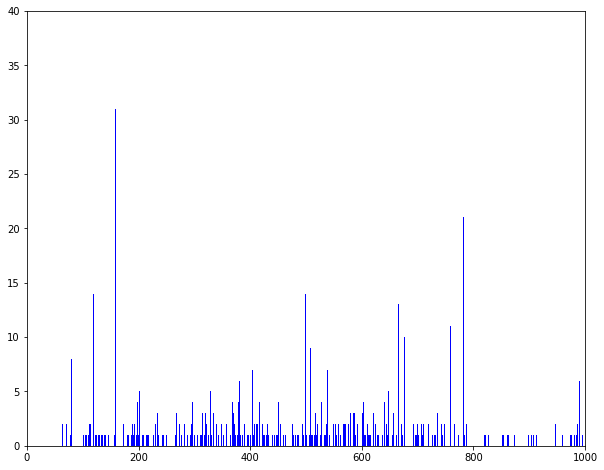

In [14]:
# PLOT AN HISTOGRAM OF IMAGE SIZES
plt.figure(figsize=(10,8))
plt.bar(list(image_size.keys()), image_size.values(), color='b')
plt.xlim((0,1000))
plt.ylim((0,40))
plt.show()

## Data Splitting

In [15]:
# CREATE A DIRECTORY FOR THE SPLITTING
try:
    os.mkdir(DIR_TRAIN_TEST_DATA)
except:
    print("Folder already found.")

In [16]:
# SPLIT THE IMAGE IN TRAIN AND TEST SETS. 65% TRAIN DATA AND 35% TEST DATA.
splitfolders.ratio(PREPROCESSED_DATA,
                   output= DIR_TRAIN_TEST_DATA,
                   seed = SEED_VALUE,
                   ratio = (.65, .20, .15)) # training, validation, testing

Copying files: 978 files [00:13, 71.06 files/s]


# 4.Data Augmentation on the train set

In this section we will apply different techniques in order to create additional images to be fed, later, into the model.
Why _Data Augmentation_? (INSERT DESCRIPTION)

In [ ]:
# RENAME THE FOLDER VAL TO TEST IN GOOGLE DRIVE

# old_name = r"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val"
# new_name = r"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test"

# try:
#   os.rename(old_name, new_name)
# except:
#   print("Folder already renamed!")

In [17]:
# CHECK AGAIN THE NUMBER OF IMAGES FOR EACH CLASSES
# COUNT THE NUMBER OF ELEMENTS IN EACH CLASS FOLDERS

# COUNT IMAGES AND CREATE A DICT
count_processed = 0
hist_dict_processed = {}

# ITERATE DIRECTORY
for path in os.listdir(DIR_TRAIN_TEST_DATA):
  if path == "train":

    print(path)
    for categories in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path)):
      print("--", categories)

      for images in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):

        # CHECK IF CURRENT PATH IS A FILE
        if os.path.isfile(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):
          count_processed += 0
        else:
          # IF IS NOT A FILE, IS A DIRECTORY. GET THE FOLDER NAME
          number_of_elements_per_folder = len([entry for entry in os.listdir(DIR_TRAIN_TEST_DATA + "/" + path + "/" + categories)])
          # print(f"The folder called {path} has a number of element(s) equal to:", number_of_elements_per_folder)
          count_processed += 1
          hist_dict_processed[categories] = number_of_elements_per_folder
  else:
    break

print()
# print('Number of folders:', count_processed, "different classes of food.")

train
-- french_fries
-- caprese_salad
-- pizza
-- greek_salad
-- sashimi
-- hot_dog
-- caesar_salad
-- hamburger
-- sushi



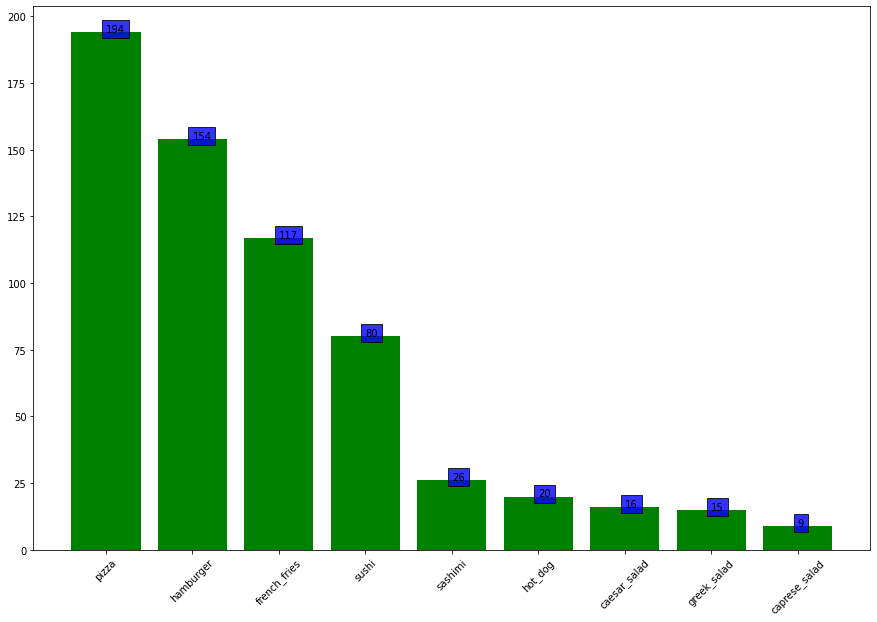

In [18]:
# FUNCTION TO ADD VALUE LABELS
def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], Bbox = dict(facecolor = 'blue', alpha =.8))

# SHOW THE DATASET DISTRIBUTION WITH A HISTOGRAM PLOT ONLY FOR THE TRAINING SET
plt.figure(figsize=(15, 10))

# CONVERT THE DICT TO DATAFRAME
new_processed = pd.DataFrame([hist_dict_processed]).transpose().reset_index()
new_processed = new_processed.rename(columns={"index": "food_name", 0: "value_count"})

# SORT THE DATAFRAME BASED ON VALUE_COUNT
new_processed = new_processed.sort_values("value_count", ascending=False)
new_processed

# PLOT THE BAR AND THE TICKS
plt.bar(new_processed['food_name'], new_processed['value_count'], color='g')
plt.xticks(rotation=45)

# CREATING DATA ON WHICH BAR CHART WILL BE PLOT
x_food_name = list(new_processed['food_name'])
y_value_count = list(new_processed['value_count'])

# CALLING THE FUNCTION TO ADD VALUE LABELS
addlabels(x_food_name, y_value_count)

It is still visible that the training set has imbalance classes, a problem that has to be faced before creating the Convolutional Neural Network model.

In [19]:
# COUNT IMAGES AND CREATE A DICT
count_images = 0

# ITERATE DIRECTORY
for path in os.listdir(DIR_TRAIN_TEST_DATA):
  if path == "train":

    print(path)
    for categories in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path)):
      print("--", categories)
      # USE https://docs.python.org/3/library/fnmatch.html TO CHECK THE SIZE OF EACH FOLDER
      category_size = len(fnmatch.filter(os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)), '*.jpg'))

      while category_size < 200:
        

        # PATH TO THE IMAGES
        category_path_folder = fnmatch.filter(os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)), '*.jpg')
        # print(DIR_TRAIN_TEST_DATA)

        # LOAD A RANDOM IMAGE AND READ IT
        random_image = random.choice(category_path_folder)
        image = cv2.imread(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, random_image))

        # PERFORM DATA AUGMENTATION
        # -------------------------
        # HORIZONTAL FLIP
        img_horiz_flipped = horizontal_flip(image, True)
        # VERTICAL FLIP
        img_vertical_flipped = vertical_flip(image, True)
        # BRIGHTNESS
        img_brightness = brightness(image, 0.5, 1.3)
        # CHANNEL SHIFT
        img_hue_image = hue_image(image, 5)
        
        # SHOW THE IMAGE
        # cv2_imshow(img_horiz_flipped)

        # SAVING THE IMAGES
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_horiz_flipped.jpg"), img_horiz_flipped)
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_vertical_flipped.jpg"), img_vertical_flipped)
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_vertical_flipped.jpg"), img_brightness)
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_vertical_flipped.jpg"), img_hue_image)
        # print(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_horiz_flipped.jpg"), img_horiz_flipped)

        # WHAT IS THE CURRENT SIZE OF THE FOLDER?
        category_size = len(fnmatch.filter(os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)), '*.jpg'))
        print("Category size is (continue until reached 1000 images in each folder):", category_size)

      else:
        # EXIT FROM THIS CATEGORY DIRECTORY IF THE NUMBER OF IMAGES INSIDE IS MORE THAN 200
        continue

  else:
    break

train
-- french_fries
Category size is (continue until reached 1000 images in each folder): 119
Category size is (continue until reached 1000 images in each folder): 121
Category size is (continue until reached 1000 images in each folder): 123
Category size is (continue until reached 1000 images in each folder): 125
Category size is (continue until reached 1000 images in each folder): 127
Category size is (continue until reached 1000 images in each folder): 129
Category size is (continue until reached 1000 images in each folder): 131
Category size is (continue until reached 1000 images in each folder): 133
Category size is (continue until reached 1000 images in each folder): 135
Category size is (continue until reached 1000 images in each folder): 137
Category size is (continue until reached 1000 images in each folder): 137
Category size is (continue until reached 1000 images in each folder): 139
Category size is (continue until reached 1000 images in each folder): 141
Category size is

In [20]:
# CHECK SIZE OF FOLDERS
print("Size of the folder caesar_salad: ",  len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/caesar_salad"), '*.jpg')))
print("Size of the folder caprese_salad: ", len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/caprese_salad"), '*.jpg')))
print("Size of the folder french_fries: ",  len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/french_fries"), '*.jpg')))
print("Size of the folder greek_salad: ",   len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/greek_salad"), '*.jpg')))
print("Size of the folder hamburger: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/hamburger"), '*.jpg')))
print("Size of the folder hot_dog: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/hot_dog"), '*.jpg')))
print("Size of the folder pizza: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/pizza"), '*.jpg')))
print("Size of the folder sashimi: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/sashimi"), '*.jpg')))
print("Size of the folder sushi: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/sushi"), '*.jpg')))

Size of the folder caesar_salad:  200
Size of the folder caprese_salad:  201
Size of the folder french_fries:  201
Size of the folder greek_salad:  201
Size of the folder hamburger:  200
Size of the folder hot_dog:  200
Size of the folder pizza:  200
Size of the folder sashimi:  200
Size of the folder sushi:  200


In [21]:
# CHECK AGAIN THE NUMBER OF IMAGES FOR EACH CLASSES
# COUNT THE NUMBER OF ELEMENTS IN EACH CLASS FOLDERS

# COUNT IMAGES AND CREATE A DICT
count_processed = 0
hist_dict_processed = {}

# ITERATE DIRECTORY
for path in os.listdir(DIR_TRAIN_TEST_DATA):
  if path == "train":

    print(path)
    for categories in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path)):
      print("--", categories)

      for images in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):

        # CHECK IF CURRENT PATH IS A FILE
        if os.path.isfile(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):
          count_processed += 0
        else:
          # IF IS NOT A FILE, IS A DIRECTORY. GET THE FOLDER NAME
          number_of_elements_per_folder = len([entry for entry in os.listdir(DIR_TRAIN_TEST_DATA + "/" + path + "/" + categories)])
          # print(f"The folder called {path} has a number of element(s) equal to:", number_of_elements_per_folder)
          count_processed += 1
          hist_dict_processed[categories] = number_of_elements_per_folder
  else:
    break

print()
# print('Number of folders:', count_processed, "different classes of food.")

train
-- french_fries
-- caprese_salad
-- pizza
-- greek_salad
-- sashimi
-- hot_dog
-- caesar_salad
-- hamburger
-- sushi



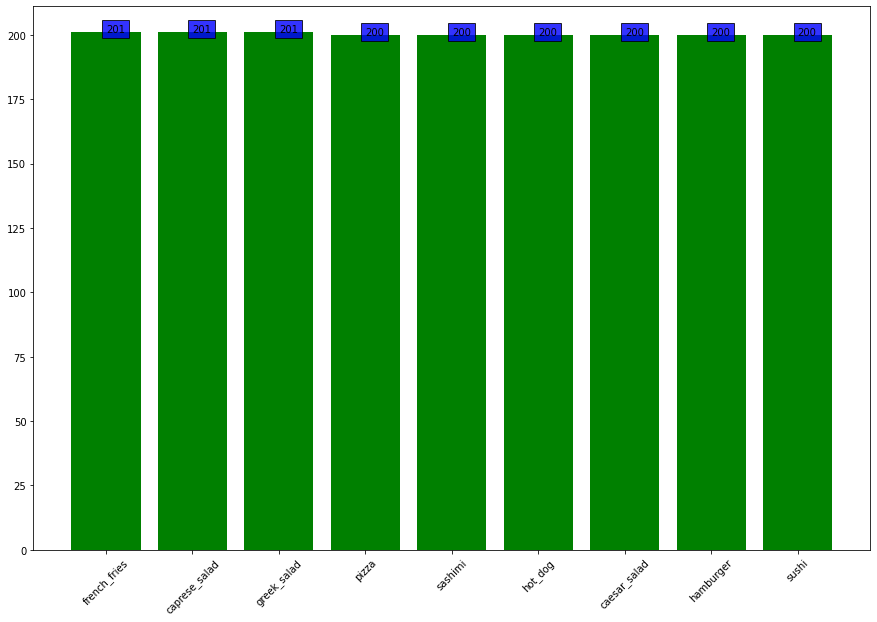

In [22]:
# FUNCTION TO ADD VALUE LABELS
def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], Bbox = dict(facecolor = 'blue', alpha =.8))

# SHOW THE DATASET DISTRIBUTION WITH A HISTOGRAM PLOT ONLY FOR THE TRAINING SET
plt.figure(figsize=(15, 10))

# CONVERT THE DICT TO DATAFRAME
new_processed = pd.DataFrame([hist_dict_processed]).transpose().reset_index()
new_processed = new_processed.rename(columns={"index": "food_name", 0: "value_count"})

# SORT THE DATAFRAME BASED ON VALUE_COUNT
new_processed = new_processed.sort_values("value_count", ascending=False)
new_processed

# PLOT THE BAR AND THE TICKS
plt.bar(new_processed['food_name'], new_processed['value_count'], color='g')
plt.xticks(rotation=45)

# CREATING DATA ON WHICH BAR CHART WILL BE PLOT
x_food_name = list(new_processed['food_name'])
y_value_count = list(new_processed['value_count'])

# CALLING THE FUNCTION TO ADD VALUE LABELS
addlabels(x_food_name, y_value_count)

### Now all the folders present a number of elements of 200 elements, solving the class unbalanced problem.

### Example of augmented images: in order to demonstrate how the data augmentation works, the following picture shows the application of brightness to a single image before applying it to multiple images in the dataset.

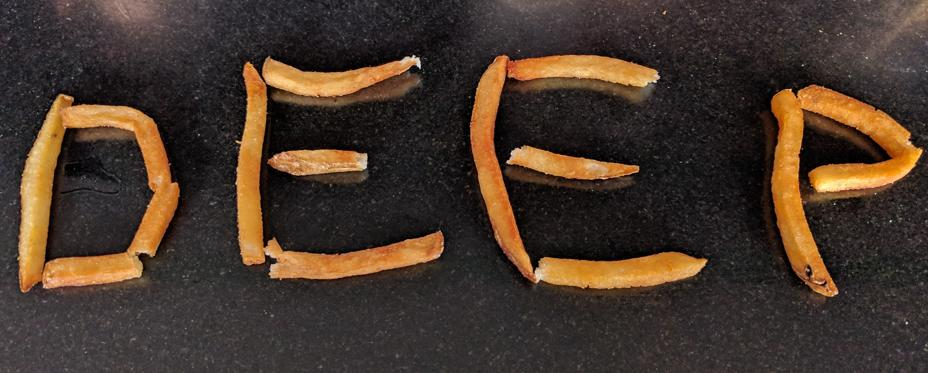

In [23]:
french_fries_brightness = cv2.imread("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/french_fries/cropfries46.jpg")
cv2_imshow(french_fries_brightness)

In [25]:
# SHOW THE SIZE OF THE IMAGE: THE IMAGE HAS BEEN RESIZED
french_fries_shape = cv2.imread("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/french_fries/20160725_123734.jpg_RESIZED.jpg")
french_fries_shape.shape

(224, 224, 3)

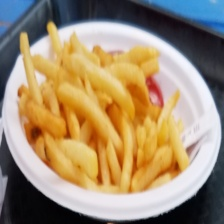

In [29]:
cv2_imshow(french_fries_shape)

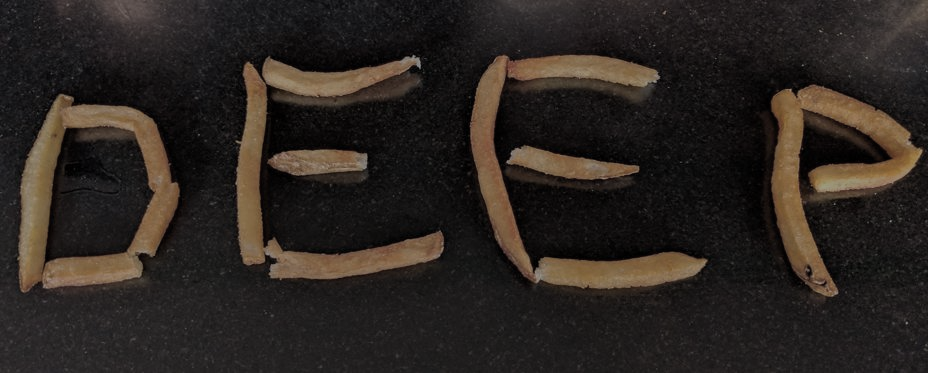

In [ ]:
# THE BRIGHTNESS FUNCTION RELIES ON A RANDOM CHOICE OF THE LOW AND HIGH VALUES.
# THEREFORE, EACH ITERATION CAN BE DIFFERENT FROM THE PREVIOUS ONE.
img_brightness = brightness(french_fries_brightness, 0.5, 1.3)
cv2_imshow(img_brightness)

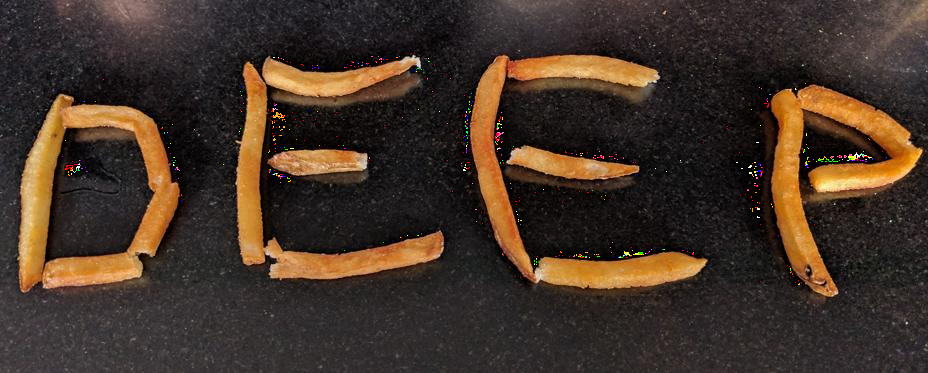

In [ ]:
img_hue_image = hue_image(french_fries_brightness, 5)
cv2_imshow(img_hue_image)

<Figure size 720x576 with 0 Axes>

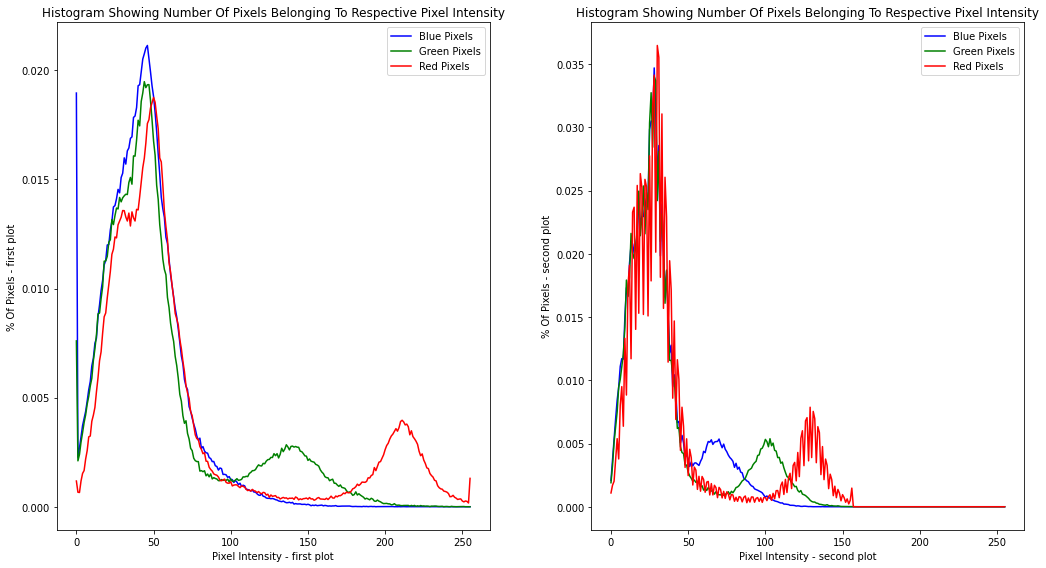

In [ ]:
# SHOW THE RGB HISTOGRAM

# SET THE SIZE OF THE PICTURE
plt.figure(figsize=(10, 8)) 

# SETTING VALUES TO ROWS, COLUMN AND COLOR VARIABLE
# rows = 2
# columns = 2
colors = ('blue','green','red')
label = ("Blue", "Green", "Red")

# the container holding the two Axes have already been unpacked
# useful if just few Axes have been created
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8)) 

# FIRST PLOT ON THE LEFT
for count,color in enumerate(colors):
    histogram = cv2.calcHist(images = [french_fries_brightness], channels = [count], mask = None, histSize = [256], ranges = [0,256])
    # NORMALIZE IT
    histogram /= histogram.sum()
    ax1.plot(histogram,color = color, label=label[count]+str(" Pixels"))

ax1.set_title('Histogram Showing Number Of Pixels Belonging To Respective Pixel Intensity')
ax1.set_xlabel('Pixel Intensity - first plot')
ax1.set_ylabel('% Of Pixels - first plot')
ax1.legend(numpoints = 1, loc = "best")

for count,color in enumerate(colors):
    histogram = cv2.calcHist(images = [img_brightness], channels = [count], mask = None, histSize = [256], ranges = [0,256])
    # NORMALIZE IT
    histogram /= histogram.sum()
    ax2.plot(histogram,color = color, label=label[count]+str(" Pixels"))

ax2.set_title('Histogram Showing Number Of Pixels Belonging To Respective Pixel Intensity')
ax2.set_xlabel('Pixel Intensity - second plot')
ax2.set_ylabel('% Of Pixels - second plot')
ax2.legend(numpoints = 1, loc = "best")

plt.tight_layout()
plt.show()

A histogram represents the distribution of pixel intensities (whether color or grayscale) in an image. It can be visualized as a graph (or plot) that gives a high-level intuition of the intensity (pixel value) distribution. We are going to assume a RGB color space in this example, so these pixel values will be in the range of 0 to 255.
Each of the red, green and blue light levels is encoded as a number in the range 0.. 255, with 0 meaning zero light and 255 meaning maximum light. So for example (red=255, green=100, blue=0) is a color where red is maximum, green is medium, and blue is not present at all, resulting in a shade of orange.

Furthermore, the bins (0-255) are plotted on the x-axis. And the y-axis counts the number of pixels in each bin.

The majority of the pixels fall in the range of roughly 5 to 60: this implies that there are a lot of "black" and very few "white" pixels in the image.
In the right figure we can see that a bigger amount of darker pixel are created, so we can say that the brightness function created a darker image than the original one.

-----------------------------------

Check this out for data augmentation:
- https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

Prossimi passi:
- creare un for loop che vada a raccogliere tutte le immagini per ciascuna cartella SOLAMENTE PER IL TRAINING SET
- se la numerosità delle immagini è < 200, allora applica trasformazioni, salva nuove immagini trasformate e se si raggiungono le 200 immagini, procedi con la cartella successiva.
- se tutto ciò funziona, usa poi la data augmentation con ImageDataGenerator per creare un numero maggiore di immagini ma solo nella fase di modellazione! (check this out: https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset; https://www.researchgate.net/post/How-many-images-does-Imagedatagenerator-generate-in-deep-learning#:~:text=Then%20the%20%22ImageDataGenerator%22%20will%20produce,there%20will%20be%20100%20iterations.)

-------------------------

# 5. Model Training
This section deals with the model creation, results and explanation.



> ## Data loader



In any deep learning framework, a data loader takes care of (at least) the following tasks:

- Loading input and target data
- Splitting the dataset into mini batches

In [26]:
base_path_train = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/'
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
base_path_val = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/'

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path_train,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            # subset='training',
                                                            shuffle=True,
                                                            seed=1)

test_dataset = keras.preprocessing.image_dataset_from_directory(base_path_test,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            # subset='validation',
                                                            shuffle=True,
                                                            seed=1)

Found 2004 files belonging to 10 classes.
Found 374 files belonging to 10 classes.


## Architecture model

## Model V01

In [ ]:
inputs = keras.Input((224, 224, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs
# 32 filtri 3x3. Padding: mi dice quanti pixel aggiungere di cornice alla mia 
# immagine prima di fare la convoluzione. Se non fornito, l'output della 
# convoluzione produrrà un immagine un pelo più piccola di quella di partenza 
# spazialmente: nel far scorrere la finestra di convoluzione non riesce a coprire
# l'intorno del pixel di riferimento nell'immagine. Dando "same" il padding
# viene calcolato automaticamente. 
x = keras.layers.Conv2D(32, 3, padding='same')(x)
# Attivazione ReLU: la funzione di attivazione introduce una non linearità.
# Fa si che il calcolo che permette di trasformare i numeri che stanno nell'input
# nei numeri che stanno nell'output non sia semplicemente una combinazione
# lineare dell'input, ma in generale crea un livello di complessità maggiore
# che è quello di costruire delle astrazioni, ovvero permette alla rete neurale
# di dire: ok, adesso ho individuato delle linee di base, ora ci costruisco
# sopra dei ragionamenti più complessi.
# x = keras.layers.Activation('relu')(x)
x = keras.layers.Activation('relu')(x)
# MaxPooling con finestre/windows 3x3 e stride di 3: ciò significa che ogni
# 3x3 valori dell'input li sostituiamo con il suo Max e poi quando spostiamo
# la finestra che esegue questa operazione, la spostiamo di 3 pixels a destra.
# Così facendo non contiamo più volte lo stesso input e in questo caso l'output
# di questo layer sarà per definizione più piccolo spazialmente dell'input.
# E' un tipo di layer che ci serve concettualmente per essere meno dipendenti
# da eventuali piccole variazioni nell'input (se ci sono tralazione dei dati
# di un pixel a destra) il Max Pooling è abbastanza robusto da queste variazioni
# trascendendo di qualche misura da variazioni dei dati. 
# Tra l'altro se lo usiamo con questo stride diminuisce la dimensione dell'input
# e la complessità dei valori che portiamo avanti nella rete neurale. Stiamo
# infatti passando da 224x224x3 valori a 3 numeri. 
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)

# Equivalente del Max Pooling ma in automatico calcola, invece che basarsi su
# una finestra 3x3 utilizza una finestra grande quanto l'intera attivazione
# del layer precedente.
x = keras.layers.GlobalMaxPooling2D()(x)

# Questa softmax prende i due numeri (le due classi specificate) e dà in input
# una funzione che ha lo scopo di produrre una pseudo distrubuzione di 
# probabilità. Si assicura che la somma dei valori (dei due valori nel nostro
# caso), faccia 1, e introduce delle non linearità.
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Con questo comando impacchettiamo tutti i nostri passaggi e diciamo 
# che la mia rete neurale è un modello che parte dalla variabile "inputs" e
# termina con la variabile chiamata "outputs". 
net = keras.Model(inputs, outputs)

In [ ]:
# La compilazione ci serve per definire quali sono le procedure utilizzate 
# durante l'addestramento. La loss in questa esercitazione non è più la differenza
# tra valore di regressione target e quello stimato ma "categorical_crossentropy".
# Per ogni immagine (dato di input) dice: guardiamo la mi ground truth. Quale era
# la classe della mia immagine? Era gatto (prima classe). Andiamo a vedere se
# nel primo dei due valori restituiti dalla rete neurale per quella immagine
# c'è un valore molto alto (idealmente deve essere 1). Più è distante la stima
# della classe attesa da 1 e maggiore è la loss (peggior risultato all'aumentare
# del valore di Loss). 
# Ottimizzatore: basato su RMSProp;
# Salviamoci l'accuracy: ci dice sul totale delle immagini quante sono state
# correttamente classificate.
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# SE LA VOLTA SCORSA POTEVAMO PERMETTERCI DI AVERE IN MEMORIA TUTTO IL DATASET
# QUA NON POSSIAMO FARE ALTRETTANTO PERCHé ABBIAMO IMMAGINI E NON C'è
# MODO DI CARICARE TUTTO IL DATASET IN MEMORIA ALLA PROCEDURA DI FIT. 
# MOTIVO PER IL QUALE STIAMO UTILIZZANDO IL DATA LOADER DEFINITO ALL'INIZIO. 
# AVENDOLO SPECIFICATO ALL'INIZIO IL TRAIN_DATASET PRENDERà IN INGRESSO 32
# IMMAGINI ALLA VOLTA, DEFINITO COME BATCH SIZE FINO A COPRIRE L'INTERO DATASET.
# COSI FACENDO HA COMPLETATO UNA EPOCA E TIRA IN BALLO IL VALIDATION
# DATA LOADER CHE CONGELA MOMENTANEAMENTE L'ADDESTRAMENTO DELLA RETE NEURALE,
# FORNISCE ALLA RETE TUTTE LE IMMAGINI DEL VALIDATION SET (ANCHE IN QUESTO
# CASO 32 ALLA VOLTA) E CALCOLA IL RISULTATO. E SALVIAMO IL RISULTATO NELLA
# VARIABILE HISTORY.
history = net.fit(train_dataset, epochs=40, validation_data = test_dataset)

<IPython.core.display.Javascript object>

Epoch 1/40
63/63 [==============================] - 98s 2s/step - loss: 19.6711 - accuracy: 0.1512 - val_loss: 8.6752 - val_accuracy: 0.2834
Epoch 2/40
63/63 [==============================] - 93s 1s/step - loss: 5.5136 - accuracy: 0.2794 - val_loss: 5.4895 - val_accuracy: 0.1497
Epoch 3/40
63/63 [==============================] - 93s 1s/step - loss: 3.2412 - accuracy: 0.3593 - val_loss: 3.4216 - val_accuracy: 0.2620
Epoch 4/40
63/63 [==============================] - 93s 1s/step - loss: 2.1604 - accuracy: 0.4611 - val_loss: 2.3904 - val_accuracy: 0.3316
Epoch 5/40
63/63 [==============================] - 94s 1s/step - loss: 1.7188 - accuracy: 0.5195 - val_loss: 2.2664 - val_accuracy: 0.3422
Epoch 6/40
63/63 [==============================] - 95s 1s/step - loss: 1.4030 - accuracy: 0.5739 - val_loss: 2.0782 - val_accuracy: 0.3636
Epoch 7/40
63/63 [==============================] - 91s 1s/step - loss: 1.2917 - accuracy: 0.6018 - val_loss: 2.7290 - val_accuracy: 0.2460
Epoch 8/40
63/63 [=

<IPython.core.display.Javascript object>

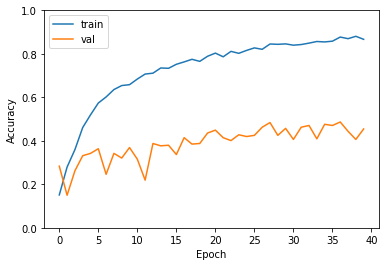

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

### Results Model V01

## Model V02 - Model with regularization and double Dense layer

In [ ]:
# Architecture definition v2
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
history = net.fit(train_dataset, epochs=40, validation_data = test_dataset)

<IPython.core.display.Javascript object>

Epoch 1/40
63/63 [==============================] - 152s 2s/step - loss: 2.0911 - accuracy: 0.4202 - val_loss: 2.6330 - val_accuracy: 0.2032
Epoch 2/40
63/63 [==============================] - 150s 2s/step - loss: 1.4108 - accuracy: 0.5928 - val_loss: 1.9250 - val_accuracy: 0.3102
Epoch 3/40
63/63 [==============================] - 152s 2s/step - loss: 1.1655 - accuracy: 0.6766 - val_loss: 1.8387 - val_accuracy: 0.3930
Epoch 4/40
63/63 [==============================] - 153s 2s/step - loss: 1.0295 - accuracy: 0.7241 - val_loss: 1.9279 - val_accuracy: 0.4011
Epoch 5/40
63/63 [==============================] - 153s 2s/step - loss: 0.8984 - accuracy: 0.7745 - val_loss: 1.6479 - val_accuracy: 0.5160
Epoch 6/40
63/63 [==============================] - 150s 2s/step - loss: 0.8114 - accuracy: 0.8114 - val_loss: 2.2183 - val_accuracy: 0.3690
Epoch 7/40
63/63 [==============================] - 152s 2s/step - loss: 0.7764 - accuracy: 0.8094 - val_loss: 2.1543 - val_accuracy: 0.3690
Epoch 8/40
63

<IPython.core.display.Javascript object>

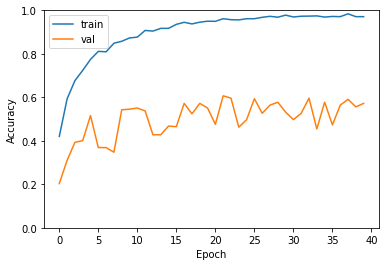

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

In [ ]:
# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 5]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

### Results Model V02

## Model V03 - Training the model with Data Agmentation from keras (regularization and dropout)

In [ ]:
# USE THIS:
# - https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

# FIRST: CREA UN'ALTRA CARTELLA IN CUI HAI TRAIN/TEST/VALIDATION E CHE UTILIZZI IN QUESTO APPROCCIO.
# QUANDO USERAI LA CROSS VALIDATION ALLORA UTILIZZA SOLO LA CARTELLA DI TRAIN E TEST MA NON QUELLA DI VALIDATION!

In [42]:
batch_size = 16
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255) 
####################################################à

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_generator = test_datagen.flow_from_directory(
    base_path_test,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

val_generator = val_datagen.flow_from_directory(
    base_path_val,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# DEFINE AN EARLY STOPPING CRITERION
# callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights = True)

In [31]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = keras.Input((224,224,3))

x = inputs
# ADD DROPOUT
# x = keras.layers.Dropout(.1)(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# ADD DROPOUT
x = tf.keras.layers.Flatten()(x)
x = keras.layers.Dropout(.15)(x)

# x = keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(512, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

In [32]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
history = net.fit(train_generator, 
                  validation_data = val_generator, # test_generator
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                  epochs=100)
                  # callbacks = [callback])

# Prova a cross validare con questo modello, vedi se ottieni risultati migliori!

- https://stackoverflow.com/questions/62341053/validation-accuracy-not-improving

In [ ]:
# Iterazioni (numero al di sotto delle epoche) viene calcolato come shape del training (in termini di lunghezza)/numero di epoche.
# Esempio: se lunghezza di training è 1803 la si divide per batch size di 64 e si ottiene 28 iterazioni per epoca! --> to see all 
# the datapoints it need 28 iterations.

In [ ]:
# SHOW DIFFERENT TRAINING EPOCHS: USE 40/70/100 TRAINING EPOCHS AND SHOW/COMMENT THE RESULTS!
# UTILE PER CAPIRE STEPS PER EPOCH AND VALIDATION STEPS: https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

In [ ]:
history.history

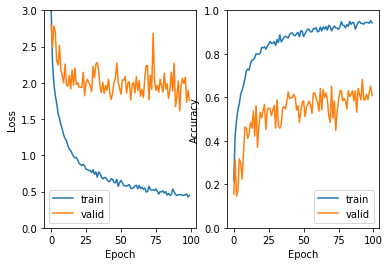

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

TO CHECK:

- https://cs230.stanford.edu/projects_fall_2019/reports/26233496.pdf
- http://www.warse.org/IJETER/static/pdf/file/ijeter38892020.pdf
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html
- https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

### Results Model V03

EXAMPLE OF NOTES THAT YOU CAN ADD:

Note:

- The increased complexity does not appear to have improved the capability of the network.
- It has, however, impacted the validation accuracy curve, which is now converging faster.
- We will now address the current behavior to implement an early stopping mechanism.

Check the following:
- https://stackoverflow.com/questions/49017331/keras-flow-from-directorydirectory
- https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

RUN THE PREVIOUS CODE FOR ANOTHER 40 EPOCHS, THEN CONTINUE WITH THE REST

---------------------

# MODEL V03.01 - Model from Keras

In [49]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((224,224,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(.20)(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

In [51]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [52]:
history = net.fit(
    train_generator,
    steps_per_epoch= train_generator.n // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps= val_generator.n // val_generator.batch_size)

# model_keras.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/100
112/112 [==============================] - 136s 1s/step - loss: 2.7998 - accuracy: 0.4555 - val_loss: 3.9889 - val_accuracy: 0.0469
Epoch 2/100
112/112 [==============================] - 134s 1s/step - loss: 2.0931 - accuracy: 0.6279 - val_loss: 3.0080 - val_accuracy: 0.2344
Epoch 3/100
112/112 [==============================] - 134s 1s/step - loss: 1.7741 - accuracy: 0.7180 - val_loss: 3.0519 - val_accuracy: 0.3490
Epoch 4/100
112/112 [==============================] - 144s 1s/step - loss: 1.5874 - accuracy: 0.7560 - val_loss: 2.5707 - val_accuracy: 0.4583
Epoch 5/100
112/112 [==============================] - 138s 1s/step - loss: 1.4959 - accuracy: 0.7577 - val_loss: 2.1596 - val_accuracy: 0.5781
Epoch 6/100
112/112 [==============================] - 135s 1s/step - loss: 1.3601 - accuracy: 0.7918 - val_loss: 2.1973 - val_accuracy: 0.5781
Epoch 7/100
112/112 [==============================] - 131s 1s/step - loss: 1.2946 - accuracy: 0.8069 - val_loss: 2.0946 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

## Model V04 - Transfer learning (and dropout)

The goal of using a pretrained model is that this model has been built to be very good at extracting useful features from images (it is called _feature extractor_).
The all convolutional layer that is not meant to do classification (the last layer) has the goal of extracting features from the images.
We will use those features in order to classify our data.

(ESTENDERE QUESTA SPIEGAZIONE IN MANIERA MIGLIORE!)

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = pretrained_model.input

# x = inputs

# ADD DROPOUT
# x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(pretrained_model.output)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Activation("relu")(x)
# x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Activation("relu")(x)
# x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Activation("relu")(x)

# x = keras.layers.GlobalMaxPooling2D()(x)

########################################
x = keras.layers.Dense(64, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(pretrained_model.output)
x = keras.layers.Dense(128, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(512, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(1024, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dropout(.1)(x)
########################################
# ADD DROPOUT
# x = keras.layers.Dropout(.1)(x)
# x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# We are using "softmax" since we want 10 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
# outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

In [ ]:
print(net.summary())

**Learning rate**
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

The amount that the weights are updated during training is referred to as the step size or the “learning rate.”

Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            # optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])


In [ ]:
history = net.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=100) #,
                  # callbacks = [callback])

Epoch 1/100
28/28 [==============================] - 92s 3s/step - loss: 3.1849 - accuracy: 0.3191 - val_loss: 3.2451 - val_accuracy: 0.1250
Epoch 2/100
28/28 [==============================] - 82s 3s/step - loss: 3.0646 - accuracy: 0.4071 - val_loss: 3.1616 - val_accuracy: 0.2344
Epoch 3/100
28/28 [==============================] - 85s 3s/step - loss: 2.9129 - accuracy: 0.4392 - val_loss: 3.1552 - val_accuracy: 0.1641
Epoch 4/100
28/28 [==============================] - 82s 3s/step - loss: 2.7542 - accuracy: 0.4629 - val_loss: 3.1258 - val_accuracy: 0.1562
Epoch 5/100
28/28 [==============================] - 81s 3s/step - loss: 2.6204 - accuracy: 0.5055 - val_loss: 2.9312 - val_accuracy: 0.3203
Epoch 6/100
28/28 [==============================] - 82s 3s/step - loss: 2.4938 - accuracy: 0.5486 - val_loss: 2.8954 - val_accuracy: 0.2969
Epoch 7/100
28/28 [==============================] - 84s 3s/step - loss: 2.3995 - accuracy: 0.5630 - val_loss: 2.8466 - val_accuracy: 0.3594
Epoch 8/100
2

KeyboardInterrupt: ignored

USEFUL LINKS:

BEST:
- https://medium.com/mlearning-ai/7-best-techniques-to-improve-the-accuracy-of-cnn-w-o-overfitting-6db06467182f
- https://sgugger.github.io/the-1cycle-policy.html

- https://www.paperspace.com/gradient/notebooks
- https://stats.stackexchange.com/questions/453221/should-i-use-gridsearchcv-on-all-of-my-data-or-just-the-training-set
- https://www.quora.com/What-kind-of-image-pre-processing-should-be-done-before-feeding-it-to-a-Convolutional-Neural-Network
- https://opt-ml.org/papers/2021/paper53.pdf
- https://towardsai.net/p/l/stop-using-grid-search-the-complete-practical-tutorial-on-keras-tuner
- https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

#### TOO LONG TO RUN! (just one epoch more than an hour!).

#### Go directly to cross validation NOT using the pretrained model!


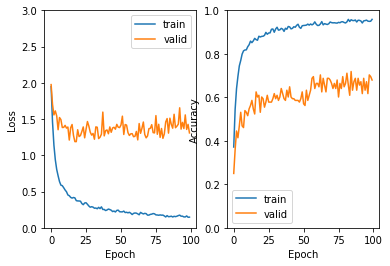

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

PRIMA DI CONTINUARE, CREA ANCHE LA DIVISIONE TRAIN/VALIDATION/TEST. DOMANI PROVA CON LA CROSS VALIDATION SOLO SU TRANING E TEST!

#### Results Model V04

## Model V05 - Cross validation: here you use only the train/test and not validation! That's because the cross validation procedure already takes a validation set in consideration!

In [ ]:
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

### Creating path dataframe

In [ ]:
# use Path object to grab all the images in a folder
caesar_salad_dir  = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/caesar_salad")
caprese_salad_dir = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/caprese_salad")
french_fries_dir  = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/french_fries")
greek_salad_dir   = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/greek_salad")
hamburger_dir     = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/hamburger")
hot_dog_dir       = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/hot_dog")
pizza_dir         = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/pizza")
sashimi_dir       = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/sashimi")
sushi_dir         = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/sushi")

In [ ]:
def generate_df(image_dir, label): 
  # get all the filepath. Convert to string for using flow_from_dataframe later
  filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name="Filepath").astype(str) # name: give the Series a name
  # labels
  labels = pd.Series(label, name="Label", index=filepaths.index)
  # concatenate two series as a dataframe
  df = pd.concat([filepaths, labels], axis=1)

  return df

In [ ]:
caesar_salad_df  = generate_df(caesar_salad_dir,  label="CAESAR_SALAD")
caprese_salad_df = generate_df(caprese_salad_dir, label="CAPRESE_SALAD")
french_fries_df  = generate_df(french_fries_dir,  label="FRENCH_FRIES")
greek_salad_df   = generate_df(greek_salad_dir,   label="GREEK_SALAD")
hamburger_df     = generate_df(hamburger_dir,     label="HAMBURGER")
hot_dog_df       = generate_df(hot_dog_dir,       label="HOT_DOG")
pizza_df         = generate_df(pizza_dir,         label="PIZZA")
sashimi_df       = generate_df(sashimi_dir,       label="SASHIMI")
caesar_salad_df  = generate_df(caesar_salad_dir,  label="CAESAR_SALAD")
sushi_df         = generate_df(sushi_dir,         label="SUSHI")

In [ ]:
all_df = pd.concat([caesar_salad_df,
                    caprese_salad_df,
                    french_fries_df,
                    greek_salad_df,
                    hamburger_df,
                    hot_dog_df,
                    pizza_df,
                    sashimi_df,
                    caesar_salad_df,
                    sushi_df], 
                   axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True) 
                   # sample and shuffle at the same time and reset index to have the correct values.
                   # drop the previous index so you do not have another column for that.

# problems:
#   - indeces are wrong
#   - the label are on top of each other and not shuffled
all_df

,Filepath,Label
0,/content/gdrive/MyDrive/Data_Science_2020-2022...,SUSHI
1,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
2,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
3,/content/gdrive/MyDrive/Data_Science_2020-2022...,HAMBURGER
4,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
...,...,...
999,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
1000,/content/gdrive/MyDrive/Data_Science_2020-2022...,FRENCH_FRIES
1001,/content/gdrive/MyDrive/Data_Science_2020-2022...,SUSHI
1002,/content/gdrive/MyDrive/Data_Science_2020-2022...,GREEK_SALAD


In [ ]:
Y_kfold = all_df[['Label']]

# kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE) 

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen_CV = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=1,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

It can be seen, that the validation_split argument is not given any value as we will be creating the validation set using one of the k splits.

We also need to save the best model in each fold.

Auxiliary function for getting model name in each of the k iterations

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

Getting the folds and creating the data generators.

In [ ]:
train_data_generator = train_datagen_CV.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=64,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE,)

test_data_generator = train_datagen_CV.flow_from_directory(
    base_path_test,
    target_size=(224,224),
    batch_size=64,
    shuffle=False,
    seed = SEED_VALUE,
    class_mode = "categorical")
	
# CREATE NEW MODEL
# DEFINE A SEQUENTIAL MODEL
def create_new_model(lr=0.001):
  model = tf.keras.models.Sequential([
  keras.Input((224, 224, 3)),

  # 1st Conv Block
  keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  # keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding='same'),

  # 2nd Conv Block
  keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  # keras.layers.BatchNormalization(),
  keras.layers.Activation("relu"),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 3rd Conv block
  keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.GlobalMaxPooling2D(),

  keras.layers.Dropout(.1),
  # Flatten(), --> TRY ALSO WITH THE FLATTEN!
  # Fully connected layers
  keras.layers.Dense(num_classes, activation='softmax')
  ])

  return model

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.


In [ ]:
from sklearn.model_selection import ParameterGrid

parameters = {'epochs': [32, 64],
              'batch_size':[32, 64],
}

param_list = list(ParameterGrid(parameters))

In [ ]:
param_list[0]['batch_size']

32

In [ ]:
learn_rate = [1e-9, 1e-3]

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
all_history = {}

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(len(all_df)), Y_kfold):
  print("fold_var number is:", fold_var)
  # print("train_index:", train_index)
  # print("val_index:", val_index)

  # EXPLAIN BETTER HOW THIS IS WORKING! CAN YOU ENSURE THAT THIS IS THE 
  # SAME SPLITTING DONE BEFORE? HOW DOES THIS SPLITTING WORKS?
  # training_data = all_df.iloc[train_index]
  # validation_data = all_df.iloc[val_index]

  # print("training_data", training_data)
  # print("validation_data", validation_data)
	 
  model_instance = create_new_model()
	# COMPILE NEW MODEL
  model_instance.compile(loss=keras.losses.categorical_crossentropy, 
                         optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=['accuracy'])
	
	# CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      save_dir+get_model_name(fold_var), 
      monitor='val_accuracy', 
      verbose=1, 
      save_best_only=True, 
      mode='max')
 
  callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	#########################################
  # INSERT THE LOOP FOR THE PARAMETERS    #
  #########################################

  # LEGGI: https://stackoverflow.com/questions/47279677/how-use-grid-search-with-fit-generator-in-keras
  # LEGGI: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
  # LEGGI: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

  # def try_fit(learn_rate):
  #   history_page=[]
  #   for lr in learn_rate:
  #     # for moment in momentum:
  #     model_instance = create_new_model(lr)
  #     model_instance.compile(loss=keras.losses.categorical_crossentropy, 
  #                       optimizer=keras.optimizers.Adam(learning_rate=lr), 
  #                       metrics=['accuracy'])
  #     history = model_instance.fit_generator(
  #         train_generator,
  #         epochs=5,
  #         validation_data = test_generator,
  #         steps_per_epoch = train_generator.n // train_generator.batch_size,
  #         validation_steps = test_generator.n // test_generator.batch_size)    
        
  #     history_page.append(history)
    
  #   return history_page

  # for param in param_list:
  #   history_page = try_fit(learn_rate)
  #   history_page[0].history['accuracy']

  #########################################
  #                                       #
  #########################################
  
  # FIT THE MODEL
  history_CV = model_instance.fit(train_data_generator,
			    epochs=5,
			    callbacks=callbacks_list,
			    validation_data=test_data_generator)

  all_history[f'history-fold-{fold_var}'] = history_CV.history


	#PLOT HISTORY
	#		:
	#		:
	# PROVA A SALVARE LA HISTORY COME è STATO FATTO QUI --> SICURAMENTE MEGLIO!
  # https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
  # https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

	# LOAD BEST MODEL to evaluate the performance of the model
  model_instance.load_weights("/saved_models/model_"+str(fold_var)+".h5")
	
  results = model_instance.evaluate(test_data_generator)
  results = dict(zip(model_instance.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

USE THIS:
CONVERT IMAGEDATAGENERATOR AS NUMPY ARRAY AND FEED THEM INSIDE GRIDSEARCHCV AS X AND Y:
- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

FOLLOWING THEN:
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

CHECK:
- https://stackoverflow.com/questions/47279677/how-use-grid-search-with-fit-generator-in-keras
- https://stackoverflow.com/questions/59023969/grid-search-hyperparameters-for-an-image-classification-model
- https://stackoverflow.com/questions/54078455/grid-search-with-gridsearchcv-scikit-learn-hyperparameter-tuning-using-image

CONVERT IMAGES TO ARRAYS
- https://www.quora.com/How-do-I-load-train-and-test-data-from-the-local-drive-for-a-deep-learning-Keras-model

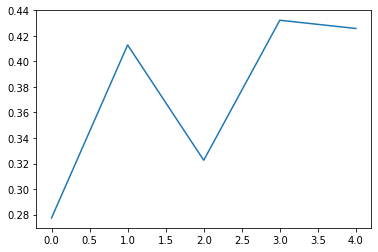

In [ ]:
plt.plot(VALIDATION_ACCURACY)

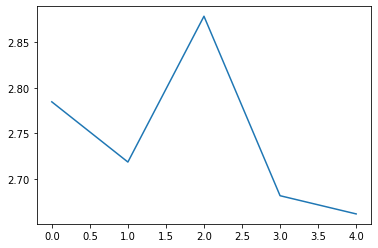

In [ ]:
plt.plot(VALIDATION_LOSS)

In [ ]:
all_history.values()

dict_values([{'loss': [3.6216585636138916, 2.5981621742248535, 2.2140607833862305, 2.0119338035583496, 1.8069442510604858], 'accuracy': [0.26012203097343445, 0.4409317672252655, 0.5330005288124084, 0.5773710608482361, 0.6289517283439636], 'val_loss': [3.214730739593506, 3.060303211212158, 2.9301836490631104, 2.8610901832580566, 2.784550905227661], 'val_accuracy': [0.1806451678276062, 0.21935483813285828, 0.26451611518859863, 0.2709677517414093, 0.2774193584918976]}, {'loss': [3.4453530311584473, 2.568146228790283, 2.193359613418579, 1.935943365097046, 1.7505513429641724], 'accuracy': [0.24736550450325012, 0.4315030574798584, 0.5219079256057739, 0.5901275873184204, 0.6317248940467834], 'val_loss': [3.163815975189209, 2.9759769439697266, 2.865057945251465, 2.720505952835083, 2.6555404663085938], 'val_accuracy': [0.18709677457809448, 0.20645160973072052, 0.3612903356552124, 0.42580646276474, 0.40645161271095276]}, {'loss': [3.7552313804626465, 2.735039234161377, 2.3069467544555664, 2.0152

# TO TRY:
1. Get all the lists of loss and accuracy
2. get the mean for each values
3. plot them!!!

# TO CHECK FOR MORE IDEAS FOR THE ARCHITECTURE
- https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/
- https://levelup.gitconnected.com/simple-image-classification-with-cnn-dd5ee3b725
- https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/
- https://www.guru99.com/convnet-tensorflow-image-classification.html

Cerca online anche altre architetture di CNN differenti e aumenta deepness dell'architettura per arrivare almeno a 10 layers!

- https://towardsdatascience.com/image-classification-with-convolutional-neural-networks-12a7b4fb4c91

Altro tipo di architettura:
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html

Try:

- https://medium.com/codex/how-to-tune-hyperparameters-for-better-neural-network-performance-b8f542855d2e
- https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
- https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04

Instead of Max pooling, you can also use fractional pooling:

https://stackoverflow.com/questions/44991470/using-tensorflow-layers-in-keras

Check the paper:
Efficient Processing DNN a tutorial and survery, page 10 for reference.

### Results Model V05

## Model V06 - GRIDSEARCH (follow: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)


    # PROVA QUANTO SEGUE:
    # Tuning the Hyperparameters and Layers of Neural Network Deep Learning:
    # https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

Non stare ad applicare anche la cross validation, ma fai direttamente GRIDSEARCHCV che tiene in consideraziona ANCHE la cross validation!

Attenzione: "As you proceed through the examples in this post, you will aggregate the best parameters. This is not the best way to grid search because parameters can interact, but it is good for demonstration purposes." Based on this comment, you should create a single hypertuning parameter model because the parameters can interact between each others. O, altrimenti, potresti anche provarli uno per uno e poi spiegare che lßappendimento era troppo lungo per poter essere processato in una volta sola in Colab perche la macchina si disconnetteva (ci sono soluzioni a parte pagare?) 

### 1. How to Tune Batch Size and Number of Epochs

In [ ]:
itr = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=1803, # you flow through the entire training dataset and get all the images, using just one batch size!
    class_mode='categorical')

X, y = itr.next()

Found 1803 images belonging to 9 classes.


KeyboardInterrupt: ignored

- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

In [ ]:
# # OPPURE:
# train_generator_GRIDSEARCHCV = train_datagen.flow_from_directory(
#     base_path_train,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

# train_generator_GRIDSEARCHCV.reset()

# X = np.concatenate([train_generator_GRIDSEARCHCV.next()[0] for i in range(train_generator_GRIDSEARCHCV.__len__())])
# y = np.concatenate([train_generator_GRIDSEARCHCV.next()[1] for i in range(train_generator_GRIDSEARCHCV.__len__())])
# print(X.shape)
# print(y.shape)

In [ ]:
model = Sequential([
          Input(shape=(224,224,3)),
          Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          Activation(activation="relu"),
          MaxPooling2D(3, strides=3, padding="same"),

          Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          Activation(activation="relu"),
          MaxPooling2D(3, strides=3, padding="same"),

          Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          Activation(activation="relu"),
          MaxPooling2D(3, strides=3, padding="same"),

          Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          Activation(activation="relu"),
          MaxPooling2D(3, strides=3, padding="same"),

          Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          BatchNormalization(),
          Activation(activation="relu"),
          GlobalMaxPooling2D(),


          Flatten(),
          Dropout(.15),
          Dense(512, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ])

In [ ]:
# # Define Sequential model with 3 layers

# # Function to create model, required for KerasClassifier
# def create_CV_model():
#   # create model
#   model = Sequential()
#   # model.add(Input((224,224,3)))
#   model = model.add(Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#   model = model.add(Activation(activation="relu"))
#   model = model.add(MaxPooling2D(3, strides=3, padding="same"))

#   # model.add(Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#   # model.add(Activation(activation="relu"))
#   # model.add(MaxPooling2D(3, strides=3, padding="same"))
#   # model.add(Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#   # model.add(Activation(activation="relu"))
#   # model.add(MaxPooling2D(3, strides=3, padding="same"))

#   # model.add(Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#   # model.add(Activation(activation="relu"))
#   # model.add(MaxPooling2D(3, strides=3, padding="same"))

#   # model.add(Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#   # model.add(BatchNormalization())
#   # model.add(Activation(activation="relu"))
#   # model.add(MaxPooling2D(3, strides=3, padding="same"))
#   # model.add(GlobalMaxPooling2D())

#   # # ADD DROPOUT
#   # model.add(Flatten())
#   # model.add(Dropout(.15))

#   # model.add(Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  
#   # OUTPUT
#   model = model.add(Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))) 

#   # Compile model
#   model = model.compile(loss=keras.losses.categorical_crossentropy,
#                 optimizer= keras.optimizers.Adam(learning_rate=0.001),
#                 metrics=['accuracy'])

#   return model

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
                # optimizer= keras.optimizers.Adam(learning_rate=0.001), # optimizer= keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

In [ ]:
# create model
model_gridsearchcv = KerasClassifier(model=model, epochs=10, verbose=10)

In [ ]:
# define the grid search parameters
batch_size = [32, 64, 128]
optimizer = ['SGD', 'RMSprop', 'Adam']
lr = [0.1, 0.01, 0.001]
# activation = ['softmax', 'relu', 'LeakyRelu']
# init_mode = ['uniform', 'lecun_uniform', 'he_uniform']
# dropout_rate = [0.0, 0.1, 0.2, 0.3] 


param_grid = dict(batch_size=batch_size, optimizer=optimizer, optimizer__learning_rate=lr) #, model__dropout_rate=dropout_rate, model__activation=activation, model__init_mode=init_mode)

grid_cv = GridSearchCV(estimator=model_gridsearchcv, param_grid=param_grid, n_jobs = 1, cv=3, error_score="raise")
grid_cv

In [ ]:
grid_cv.fit(X, y)

In [ ]:
print("Best: %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))
means = grid_cv.cv_results_['mean_test_score']
stds = grid_cv.cv_results_['std_test_score']
params = grid_cv.cv_results_['params']

In [ ]:
# grid_result_history = grid_cv.fit(X, y, # test_generator
#                        steps_per_epoch = train_generator.n // train_generator.batch_size,
#                        validation_steps = val_generator.n // val_generator.batch_size)# test_generator
#                        # callbacks = [callback])

### Results Model V06

# CONCLUSA LA GRIDSEARCH, TESTA ANCHE 

# CROSS VALIDATION: Metti a posto cross validation codice.
# GRIDSEARCHCV: Scrivi codice per gridsearchCV con tutti i parametri separati. Dopodiché consideri tutti i best parametri scelti da gridsearchCV e usali per il modello finale.

# Considera, nella parte finale, di aumentare le immagini ad almeno 1000 per classe (se non addirittura a 2000/3000)

# 6. Evaluate and Test on the test data

# 7. Results Analysis

# 8. Deploy in data app --> chek this out: https://dev.to/code_jedi/how-to-turn-your-python-machine-learning-code-into-a-web-app-2hfc

# 9. Future Work and Improvements

# References:

- https://medium.com/free-code-camp/everything-you-need-to-know-to-master-convolutional-neural-networks-ef98ca3c7655

- https://medium.com/mlearning-ai/computer-vision-exploring-your-image-datasets-the-right-way-538c5ae8ca5d

CNN EXPLAINED
- https://www.youtube.com/watch?v=pj9-rr1wDhM

CNN
- https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

DATA AUGMENTATION
- https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/#:~:text=Keras%20ImageDataGenerator%20is%20a%20gem,up%20on%20the%20overhead%20memory!
- https://www.analyticsvidhya.com/blog/2021/06/offline-data-augmentation-for-multiple-images/
- https://github.com/AISangam/Image-Augmentation-Using-OpenCV-and-Python/blob/master/Image%20Augmentaion%20Part1.py

HISTOGRAMS FOR COLORS IN IMAGE
- https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/
- https://web.stanford.edu/class/cs101/image-1-introduction.html#:~:text=Each%20of%20the%20red%2C%20green,in%20a%20shade%20of%20orange.

MANIFOLD
- https://towardsdatascience.com/manifolds-in-data-science-a-brief-overview-2e9dde9437e5

DROPOUT
- https://stackoverflow.com/questions/47892505/dropout-rate-guidance-for-hidden-layers-in-a-convolution-neural-network

FINE-TUNING
- https://towardsdatascience.com/fine-tuning-a-cnn-model-for-image-classification-a886e4b539b3
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

CROSS-VALIDATION KERAS
- https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554